From: [https://gsarantitis.wordpress.com/2020/04/29/auc-roc-gains-chart-and-lift-curve-explained-with-business-implications/](https://gsarantitis.wordpress.com/2020/04/29/auc-roc-gains-chart-and-lift-curve-explained-with-business-implications/)

Data source: [http://archive.ics.uci.edu/dataset/222/bank+marketing](http://archive.ics.uci.edu/dataset/222/bank+marketing)

In [13]:
#Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score,precision_score
sns.set_style("whitegrid")
%matplotlib inline

In [14]:
#Import and preprocess data
df = pd.read_csv('data/bank-full.csv', sep=';')
 
#Encode categorical variables
print('Converting categorical variables to numeric...')
 
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                       'contact', 'day', 'month', 'campaign','previous', 'poutcome']
 
use_cols = ['month', 'campaign', 'y']
 
df['y'] = df['y'].map({'yes':1, 'no':0})
 
for c in categorical_columns:
    df[c] = df[c].astype('category')
    df[c] = df[c].cat.codes

Converting categorical variables to numeric...


In [15]:
#Split in 75% train and 25% test set
train_df, test_df = train_test_split(df, test_size = 0.25, random_state= 1984)
 
#Separate target label
train_y = train_df['y']
test_y = test_df['y']
 
#Drop target label
train_x = train_df.drop(['y'], axis = 1)
test_x = test_df.drop(['y'], axis = 1)

In [16]:
#Build Random Forest model
model1 = RandomForestClassifier(max_depth=4, n_estimators = 20)
model1.fit(train_x,train_y)
model2 = RandomForestClassifier(max_depth=12, n_estimators = 120)
model2.fit(train_x,train_y)
 
#Predict test set
pred_1 = model1.predict(test_x)
pred_2 = model2.predict(test_x)
pred_prob_1 = model1.predict_proba(test_x)
pred_prob_2 = model2.predict_proba(test_x)

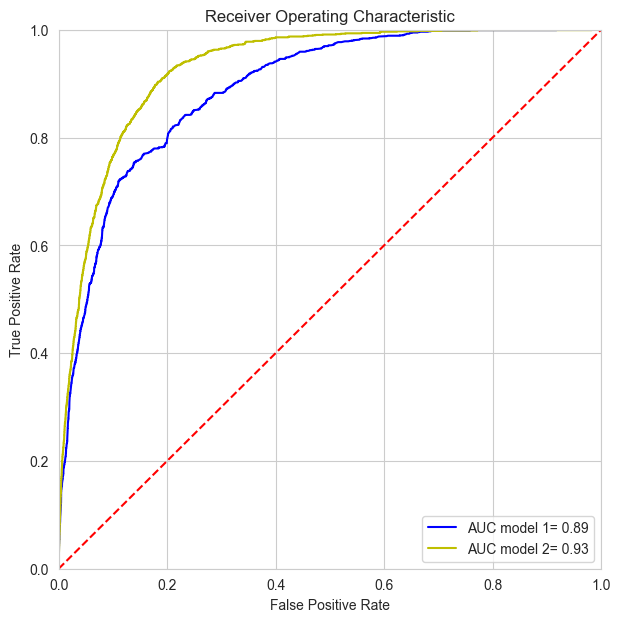

In [17]:
#Plot AUC-ROC
fpr1, tpr1, threshold1 = roc_curve(test_y, pred_prob_1[:,1])
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, threshold2 = roc_curve(test_y, pred_prob_2[:,1])
roc_auc2 = auc(fpr2, tpr2)
 
plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC model 1= %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'y', label = 'AUC model 2= %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<Figure size 700x700 with 0 Axes>

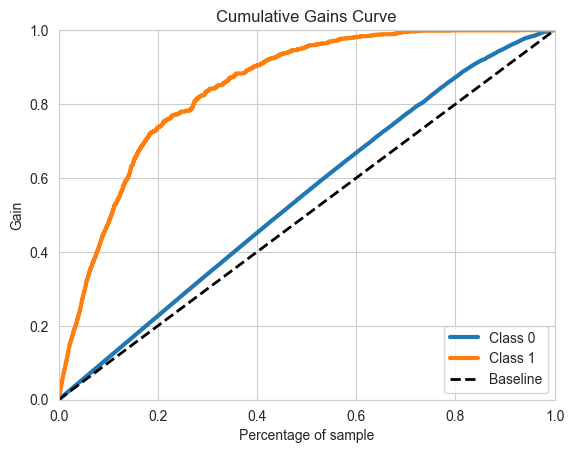

In [18]:
# Cumulative Gains Curve
plt.figure(figsize=(7,7))
skplt.metrics.plot_cumulative_gain(test_y, pred_prob_1)
plt.show()

<Figure size 700x700 with 0 Axes>

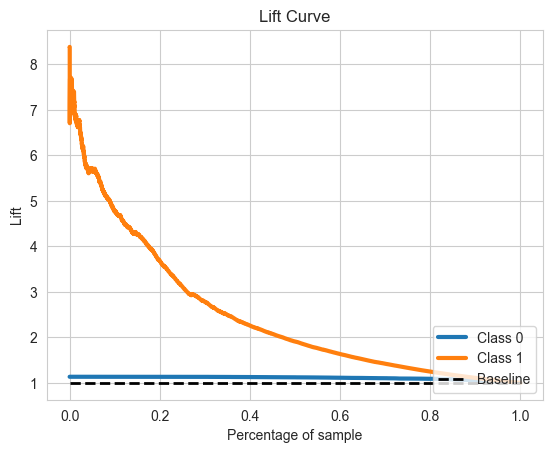

In [19]:
# Lift Curve
plt.figure(figsize=(7,7))
skplt.metrics.plot_lift_curve(test_y, pred_prob_1)
plt.show()

In [20]:
# --------------------------------
# Function to calculate response rate, cumulative gain and lift
# @Params:
# y_val: real labels of the data
# y_pred: probability predictions for such data
# q: number of quantiles (eg 10 for deciles)
# --------------------------------
def calculate_lift(y_val, y_pred, q=10):
    #Create auxiliary dataframe to store the real value and predicted probabilities
    aux_lift = pd.DataFrame()
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    
    #Drop missing observations with no value
    aux_lift = aux_lift.loc[aux_lift['predicted'].notnull()]
    # drop customers where score is over highest non-customer
    max_de = aux_lift["predicted"].where(aux_lift["real"] == 0).max()
    aux_lift.drop(aux_lift.index[aux_lift['predicted'] > max_de], inplace=True)
    aux_lift.reset_index()
    #Rank the scored file, in descending order by estimated probability 
    aux_lift = aux_lift.sort_values(by='predicted', ascending=False)

    #Split the ranked file into deciles (q is the number of scorecards to be used)
    aux_lift['percentile'] = pd.qcut(aux_lift['predicted'].where(aux_lift['real'] == 0).rank(method='first'), q=q, labels=False)
    #get the minimum predicted values of real 0 per quantile
    percentile_limits = aux_lift.groupby(['percentile']).min().predicted
    percentile_limits = percentile_limits.to_dict()
    #put real 1s in the equivalent score class based on their minimum value
    for quantil, min_score in percentile_limits.items():
        aux_lift.loc[aux_lift.predicted > min_score, 'percentile'] = quantil
    
    #turn the scores so that 1 is the best scoreclass
    aux_lift['percentile'] = q - aux_lift['percentile']

    #Overal response rate (threshold)
    total_num_customers = len(aux_lift)
    total_responses = aux_lift.real.value_counts()[1]
    response_rate = total_responses/total_num_customers*100
    
    #Create final dataframe to store the lift and gain scores
    lift = pd.DataFrame()
    
    #Observations in each percentile
    lift['num_customers'] = (aux_lift.groupby('percentile').size()).astype(int)
    lift['cum_customers'] = np.cumsum(lift['num_customers'])
    lift['cum_pct_customers'] = ((lift['cum_customers']/total_num_customers)*100).round(2)

    #Response rate in each percentile
    lift['num_responses'] = (aux_lift.groupby('percentile')['real'].sum()).astype(int)
    lift['response_rate'] = ((lift['num_responses']/lift['num_customers'])*100).round(2)
    lift['cum_responses'] = np.cumsum(lift['num_responses'])

    #Cumulative gain
    lift['pct_gain'] = ((lift['num_responses']/total_responses)*100).round(2)
    lift['cum_gain'] = ((lift['cum_responses']/total_responses)*100).round(2) #also known as cummulative gain
    #Lift score
    lift['lift'] = (lift['pct_gain'] / lift['pct_gain'].mean()).round(2)
    
    #Cumulative lift score
    lift['cum_lift'] = ((lift['cum_gain']/lift.index)/ lift['pct_gain'].mean()).round(2)
    
    return lift

In [21]:
# --------------------------------
# Function to plot lift curve
# @Params:
# y_val: real labels of the data
# y_pred: probability predictions for such data
# q: number of quantiles (eg 10 for deciles)
# --------------------------------
def plot_lift_curve_own(y_val, y_pred, q=10, proportion=False):
    #Calculate lift & cumulative lift score
    lift = calculate_lift(y_val, y_pred, q)
    
    #Cumulative  lift curve
    values = lift['cum_lift'].round(2)
    if proportion:
        x = np.arange(1./q, 1+1/q, 1./q) # THIS WOULD BE PROPORTION
    else:
        x = list(range(1, len(values)+1)) # THIS IS QUANTILE
    
    sample_size = lift['num_customers'].sum()
    sample_size = "\nSample size={:0.0f}".format(sample_size)
    
    fig, ax = plt.subplots()
    ax.plot(x, values, c='orange', linewidth=2)
    ax.plot(x, lift['lift'], c='gray', linewidth=2)
    ax.axhline(lift['lift'].mean(), linewidth=2, color='k', linestyle='--')
    # ax.set_xticks(list(range(1, len(values)+1))) # NO NEED
    if proportion:
        ax.set_xlabel('Proportion of sample\n'+sample_size)
    else:
        ax.set_xlabel(f"Quantile\n"+sample_size) 
    ax.set_ylabel('Lift')
    ax.set_title('Lift Curve')
    plt.savefig('lift_curve_'+y_val.name[-2:]+'.png', dpi=300, bbox_inches='tight')
    plt.show()

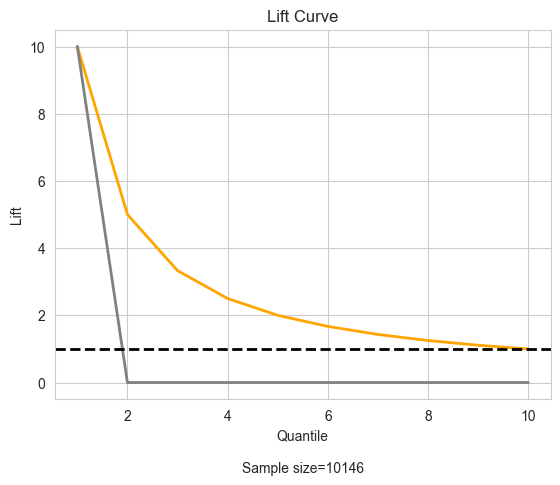

In [22]:
plot_lift_curve_own(test_y, pred_1, q=10, proportion=False)
plt.show()